total time: 0.45162367820739746
Labels: [7 7 7 ... 7 7 7] (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 134,  950,  212,  344,   57,    2,   78,  421,   48, 2260]))
boundaries 414
axes [<matplotlib.axes._subplots.AxesSubplot object at 0x7f75552c13c8>
average 0.2973029613494873
complete 0.2974526882171631
ward 0.4702591896057129


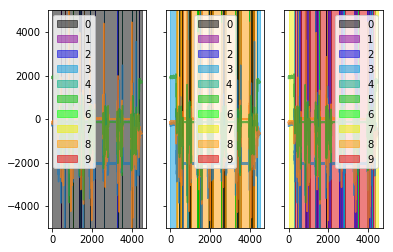

In [6]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph


N = 10
link_types = ('average', 'complete', 'ward')
event_labels = {i:i for i in range(N)}


FILE = 'data/pills-s0.npy'


def to_range(l, cmap):
    total = cmap.N
    idx = int((l[-1] / N) * total)
    return cmap(idx)

def boundaries(v):
    bounds = [0] + list(np.where(v[:-1] != v[1:])[0] + 1) + [len(v)-1]
    return [(bounds[i], bounds[i+1], v[bounds[i]]) for i in range(len(bounds)-1)]

def plot_bounds(ax, x, z):
    Zb = boundaries(z)
    ax.plot(x[:,:-3], alpha=.7)
    ax.set_ylim(-5000, 5000)
    # plot labels
    _cmap = plt.get_cmap('nipy_spectral')
    plots = {}
    for l in Zb:
        ev = event_labels[l[-1]]
        i = ax.axvspan(l[0], l[1], color=to_range(l, _cmap), alpha=0.5, label=ev)
        plots[ev] = i
    # legend
    legs = [plots[event_labels[i]] for i in sorted(event_labels)]
    nms = [event_labels[i] for i in sorted(event_labels)]
    ax.legend(legs, nms)


X = np.load(FILE)
idx = np.arange(X.shape[0])
model = AgglomerativeClustering(linkage=link_types[2], n_clusters=N)

# train
t0 = time.time()
model.fit(X)
elapsed_time = time.time() - t0
print('total time:', elapsed_time)

lbls = model.labels_
counts = np.unique(lbls, return_counts=True)
print('Labels:', model.labels_, counts)
bounds = boundaries(lbls)
print('boundaries', len(bounds))


fig, axes = plt.subplots(nrows=1, ncols=len(link_types), sharey='row', figsize=(12, 12))
print('axes', axes)


for i, tp in enumerate(link_types):
    ax = axes[i]
    model = AgglomerativeClustering(linkage=tp, n_clusters=N)
    # train
    t0 = time.time()
    model.fit(X)
    elapsed_time = time.time() - t0
    print(tp, elapsed_time)
    plot_bounds(ax, X, model.labels_)

plt.show()